# Yield Prediction using DRFP (SMILES)

##  Dataset Description

This dataset originates from a recent publication by a Pfizer team. Utilizing flow chemistry, they conducted a high-throughput reaction screening of the Suzuki–Miyaura C–C coupling reaction. This screening involved 11 reactants, 12 ligands, 8 bases, and 4 solvents, resulting in a total of 5760 reactions. The predictive target in this dataset is the reaction yield. (D. Perera, J. W. Tucker, S. Brahmbhatt, C. J. Helal, A. Chong, W. Farrell, P. Richardson and N. W. Sach, Science, 2018, 359, 429–434.)

The objective of this notebook is to introduce a method for predicting yiel using DRFP (fingerprints) and non-linear model (XGBoost).

As a beginner, there may be numerous opportunities for improvement in this notebook. 
I was largely inspired by the work of Alexander A. Ksenofontov and co (10.1016/j.jocs.2023.102173),Jean-Louis Reymond and co (10.1039/d1dd00006c) and the André OLIVEIRA's notebook (Predicting molecule properties based on its SMILES), thanks to them. 

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import os 
import sys
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
import shap
import cairo
import pandas as pd
import seaborn as sns
IPythonConsole.molSize = (300, 300)
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
shap.initjs()

# DL Dataset

In [2]:
data = r"..\data\Suzuki-Miyaura\aap9112_Data_File_S1.xlsx"

dataF = pd.read_excel(data)

df = dataF.copy()

In [3]:
pd.set_option("display.max_rows", 5760)
pd.set_option("display.max_columns", 16)

In [4]:
df.head(100)

,Reaction_No,Reactant_1_Name,Reactant_1_Short_Hand,Reactant_1_eq,Reactant_1_mmol,Reactant_2_Name,Reactant_2_eq,Catalyst_1_Short_Hand,Catalyst_1_eq,Ligand_Short_Hand,Ligand_eq,Reagent_1_Short_Hand,Reagent_1_eq,Solvent_1_Short_Hand,Product_Yield_PCT_Area_UV,Product_Yield_Mass_Ion_Count
0,1,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(tBu)3,0.125,NaOH,2.5,MeCN,4.764109,6262.058822
1,2,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(Ph)3,0.125,NaOH,2.5,MeCN,4.120962,13245.570909
2,3,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,AmPhos,0.125,NaOH,2.5,MeCN,2.583837,3009.165946
3,4,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(Cy)3,0.125,NaOH,2.5,MeCN,4.443171,30860.698262
4,5,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(o-Tol)3,0.125,NaOH,2.5,MeCN,1.949874,2486.306423
5,6,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,CataCXium A,0.125,NaOH,2.5,MeCN,3.250809,9592.454300
6,7,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,SPhos,0.125,NaOH,2.5,MeCN,86.262122,108343.141930
7,8,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,dtbpf,0.125,NaOH,2.5,MeCN,7.546080,9373.403347
8,9,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,XPhos,0.125,NaOH,2.5,MeCN,93.674515,27239.202786
9,10,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,dppf,0.125,NaOH,2.5,MeCN,14.321435,7746.462857


In [4]:
df.shape

(5760, 16)

# Replace molecule's label by SMILES (found thanks to Chemspider)

I chose SMILES for molecular representation

In [5]:
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-chloroquinoline", "c1cc2cc(ccc2nc1)Cl")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Bromoquinoline", "c1cc2cc(ccc2nc1)Br")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-triflatequinoline", "c1cc2cc(ccc2nc1)OS(=O)(=O)C(F)(F)F")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Iodoquinoline", "c1cc2cc(ccc2nc1)I")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-quinoline-boronic acid hydrochloride", "B(c1ccc2c(c1)cccn2)(O)O.Cl")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("Potassium quinoline-6-trifluoroborate", "[B-](c1ccc2c(c1)cccn2)(F)(F)F.[K+]")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Quinolineboronic acid pinacol ester", "B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3")

In [6]:
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2a, Boronic Acid", "B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2b, Boronic Ester", "B1(OC(C(O1)(C)C)(C)C)c2c(ccc3c2cnn3C4CCCCO4)C")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2c, Trifluoroborate", "CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.[K+]")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2d, Bromide", "Cc1ccc2c(c1Br)cnn2C3CCCCO3")

In [7]:
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(tBu)3", "CC(C)(C)P(C(C)(C)C)C(C)(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(Ph)3 ", "c1ccc(cc1)P(c2ccccc2)c3ccccc3")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("AmPhos", "P(c1ccc(cc1)N(C)C)(C(C)(C)C)C(C)(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(Cy)3", "C1CCC(CC1)P(C2CCCCC2)C3CCCCC3")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(o-Tol)3", "Cc1ccccc1P(c2ccccc2C)c3ccccc3C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("CataCXium A", "P(C13CC2CC(C1)CC(C2)C3)(CCCC)C46CC5CC(CC(C4)C5)C6")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("SPhos", "COc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("dtbpf", "CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.[Fe]")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("XPhos", "CC(C)c1cc(c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CCCCC4)C(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("dppf", "c1ccc(cc1)P(c2ccccc2)C34C5[Fe]3678912(C5C6C74)C3C8C9C1(C23)P(c1ccccc1)c1ccccc1")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("Xantphos", "CC1(c2cccc(c2Oc3c1cccc3P(c4ccccc4)c5ccccc5)P(c6ccccc6)c7ccccc7)C")

In [8]:
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("NaOH", "[OH-].[Na+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("NaHCO3", "C(=O)(O)[O-].[Na+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("CsF", "[F-].[Cs+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("K3PO4", "[O-]P(=O)([O-])[O-].[K+].[K+].[K+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("KOH", "[OH-].[K+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("LiOtBu", "[Li+].CC(C)(C)[O-]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("Et3N", "CCN(CC)CC")

In [9]:
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeCN", "CC#N")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("DMF", "CN(C)C=O")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("THF", "C1CCOC1")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeOH", "CO")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeOH/H2O_V2 9:1", "CO")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("THF_V2", "CO")

In [10]:
df["Catalyst_1_Short_Hand"] = df["Catalyst_1_Short_Hand"].replace("Pd(OAc)2", "CC(=O)[O-].CC(=O)[O-].[Pd+2]")

In [11]:
df["Reagent_1_Short_Hand"].value_counts()

Reagent_1_Short_Hand
[OH-].[Na+]                           720
C(=O)(O)[O-].[Na+]                    720
[F-].[Cs+]                            720
[O-]P(=O)([O-])[O-].[K+].[K+].[K+]    720
[OH-].[K+]                            720
[Li+].CC(C)(C)[O-]                    720
CCN(CC)CC                             720
Name: count, dtype: int64

# Adding features : SMART (converting from SMILES)

In [12]:
# Function to convert a smiles to smart
def smiles_to_smart(name):
    mol = Chem.MolFromSmiles(name)
    sma = Chem.MolToSmarts(mol)
    return sma

In [13]:
# Add "Reactant_1_Name_SMART"
df["Reactant_1_Name_SMART"] = df["Reactant_1_Name"].apply(smiles_to_smart)

# Add "Reactant_2_Name_SMART"
df["Reactant_2_Name_SMART"] = df["Reactant_2_Name"].apply(smiles_to_smart)

# Add "Solvent_1_Short_Hand_SMART"
df["Solvent_1_Short_Hand_SMART"] = df["Solvent_1_Short_Hand"].apply(lambda x: smiles_to_smart(x))  # other way 

# Add "Catalyst_1_Short_Hand_SMART"
df["Catalyst_1_Short_Hand_SMART"] = df["Catalyst_1_Short_Hand"].apply(smiles_to_smart)

In [14]:
# Add "Reagent_1_Short_Hand_SMART"
for index, value in df["Reagent_1_Short_Hand"].items():  
    if not isinstance(value, float): # check is values egal to nan (float)
        df.at[index, "Reagent_1_Short_Hand_SMART"]= smiles_to_smart(value)

# df["Reagent_1_Short_Hand_SMART"] = df["Reagent_1_Short_Hand"].apply(smiles_to_smart) ## doesn't work so replace it one by one, because some values are egal to nan

# Add "Ligand_Short_Hand_SMART"
for index, value in df["Ligand_Short_Hand"].items():
    if not isinstance(value, float): 
        df.at[index,"Ligand_Short_Hand_SMART"] = smiles_to_smart(value)

In [15]:
df.shape

(5760, 22)

# Creat the Product Feature

In [16]:
df["Product"] = "Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1"  # SMILE obtaint thanks to Chemdraw 

In [17]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['Product'].apply(lambda x: Chem.MolFromSmiles(x))

#Now let's see what we've got
print(df['mol'][0])

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


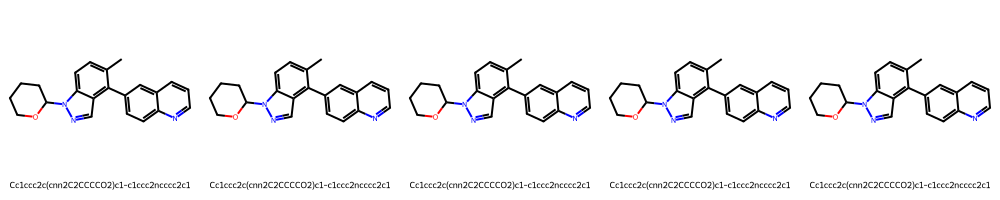

In [18]:
mols = df['mol'][:5]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['Product'][:5].values))

In [19]:
df["Product_SMART"] = smiles_to_smart("Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1")

In [20]:
df.head()

,Reaction_No,Reactant_1_Name,Reactant_1_Short_Hand,Reactant_1_eq,Reactant_1_mmol,Reactant_2_Name,Reactant_2_eq,Catalyst_1_Short_Hand,...,Reactant_2_Name_SMART,Solvent_1_Short_Hand_SMART,Catalyst_1_Short_Hand_SMART,Reagent_1_Short_Hand_SMART,Ligand_Short_Hand_SMART,Product,mol,Product_SMART
0,1,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6])...,[#6]-[#6]#[#7],[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-]....,[#8-].[Na+],[#6]-[#6](-[#6])(-[#6])-[#15](-[#6](-[#6])(-[#...,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000243F5B...,[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7...
1,2,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6])...,[#6]-[#6]#[#7],[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-]....,[#8-].[Na+],[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#15](-[#6]...,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000243F5B...,[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7...
2,3,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6])...,[#6]-[#6]#[#7],[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-]....,[#8-].[Na+],[#15](-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]...,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000243F5B...,[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7...
3,4,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6])...,[#6]-[#6]#[#7],[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-]....,[#8-].[Na+],[#6]1-[#6]-[#6]-[#6](-[#6]-[#6]-1)-[#15](-[#6]...,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000243F5B...,[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7...
4,5,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6])...,[#6]-[#6]#[#7],[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-]....,[#8-].[Na+],[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#15](-[...,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000243F5B...,[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7...


# Drawing Chemical Reaction (For Fun)

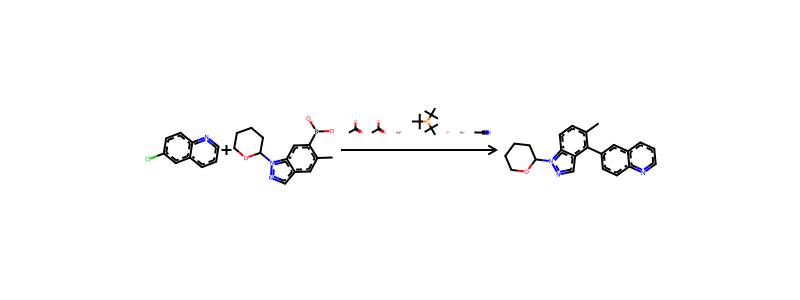

In [21]:
from rdkit.Chem import Draw
from IPython.display import display, Image  # Import Image class
import cairo
import io

# creat reaction
rxn = AllChem.ReactionFromSmarts('[#6]1:[#6]:[#6]2:[#6]:[#6](:[#6]:[#6]:[#6]:2:[#7]:[#6]:1)-[#17].[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6]):[#6]:[#7]:[#7]:2-[#6]1-[#6]-[#6]-[#6]-[#6]-[#8]-1)(-[#8])-[#8]>[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-].[Pd+2].[#6]-[#6](-[#6])(-[#6])-[#15](-[#6](-[#6])(-[#6])-[#6])-[#6](-[#6])(-[#6])-[#6].[#8H-].[Na+].[#6]-[#6]#[#7]>[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7]:2-[#6]2-[#6]-[#6]-[#6]-[#6]-[#8]-2):[#6]:1-[#6]1:[#6]:[#6]:[#6]2:[#7]:[#6]:[#6]:[#6]:[#6]:2:[#6]:1')

d2d = Draw.MolDraw2DCairo(800,300)
d2d.DrawReaction(rxn)
png = d2d.GetDrawingText()

# Convert the PNG image data to bytes
png_bytes = io.BytesIO(png)

# Create an Image object and display it in the notebook
display(Image(data=png_bytes.getvalue()))

In [22]:
print("Number of Agent",rxn.GetNumAgentTemplates()) # Number of Agent
print("Number of Product",rxn.GetNumProductTemplates()) # Number of Product
print("Number of Reactant",rxn.GetNumReactantTemplates()) # Number of Reactant

Number of Agent 7
Number of Product 1
Number of Reactant 2


## Creat all chemical reaction SMILE

In [23]:
df["Ligand_Short_Hand"].fillna("", inplace=True)
df["Reagent_1_Short_Hand"].fillna("", inplace=True)

df["Chemical_react"] = df["Reactant_1_Name"].str.cat(df["Reactant_2_Name"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Solvent_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Catalyst_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Reagent_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Ligand_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Product"], sep='>>')


In [24]:
df["Chemical_react"][0]

'c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2].[OH-].[Na+].CC(C)(C)P(C(C)(C)C)C(C)(C)C>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

In [25]:
df["Chemical_react"][4999]

'[B-](c1ccc2c(c1)cccn2)(F)(F)F.[K+].Cc1ccc2c(c1Br)cnn2C3CCCCO3.CO.CC(=O)[O-].CC(=O)[O-].[Pd+2]..CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.[Fe]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

In [26]:
df["Chemical_react"][93]

'c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2]..c1ccc(cc1)P(c2ccccc2)C34C5[Fe]3678912(C5C6C74)C3C8C9C1(C23)P(c1ccccc1)c1ccccc1>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

# Fingerprint DRFP

## Fingerprint DRFP one chemical reaction

In [27]:
SMILE = "CO.O.O=C(NC(=S)Nc1nc(-c2ccccc2)cs1)c1ccccc1.[Na+].[OH-]>>NC(=S)Nc1nc(-c2ccccc2)cs1"
fps1, mapping1 = DrfpEncoder.encode(SMILE, mapping=True, n_folded_length=128)
print(SMILE)
print(np.nonzero(fps1[0]))

CO.O.O=C(NC(=S)Nc1nc(-c2ccccc2)cs1)c1ccccc1.[Na+].[OH-]>>NC(=S)Nc1nc(-c2ccccc2)cs1
(array([  6,   7,   8,  13,  25,  29,  35,  37,  40,  41,  43,  50,  55,
        61,  63,  67,  68,  73,  77,  87,  90, 100, 105, 108, 112, 113,
       116, 125]),)


In [28]:
fps1

[array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)]

In [29]:
fps1[0]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [30]:
print(np.nonzero(fps1[0]))

(array([  6,   7,   8,  13,  25,  29,  35,  37,  40,  41,  43,  50,  55,
        61,  63,  67,  68,  73,  77,  87,  90, 100, 105, 108, 112, 113,
       116, 125]),)


The fps shows whether one feature is present or not (1 or 0) and his indexing because it's an array. Exemple, we saw in fps that 1 appears to the third indexing values (0,0,0,1), indeed in np.nonzero(fps[0])) we have 3.

## Fingerprint DRFP all chemical reaction SMILE

In [31]:
fps2, mapping2 = DrfpEncoder.encode(df["Chemical_react"].values, mapping=True, n_folded_length=128)

In [32]:
print(df["Chemical_react"][0])
print(np.nonzero(fps2[0]))

c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2].[OH-].[Na+].CC(C)(C)P(C(C)(C)C)C(C)(C)C>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1
(array([  3,   4,   5,   7,   8,   9,  11,  12,  13,  14,  15,  17,  18,
        21,  22,  25,  29,  31,  32,  33,  34,  36,  38,  39,  40,  41,
        44,  45,  50,  51,  54,  55,  56,  59,  61,  63,  64,  66,  67,
        74,  75,  77,  78,  84,  87,  88,  91,  92,  95,  96,  99, 103,
       105, 107, 112, 113, 114, 115, 120, 121, 124, 127]),)


In [33]:
ngrams = list(mapping2[list(mapping2.keys())[0]])
print(ngrams)
ngrams = list(mapping2[list(mapping2.keys())[1]])
print(ngrams)

['[c]12[cH][cH][cH][n][c]1[cH][cH][c](-[cH3])[cH]2', '[CH]([CH3])([CH3])[c]([cH][cH2])[c]([cH2])-[cH3]', '[c]([cH][cH2])([cH][cH2])-[c]([cH2])[cH2]', '[Br][c]([c]([cH2])[CH3])[c]([cH2])[cH2]']
['[cH]([cH][cH2])[c]([cH2])-[cH3]']


In [34]:
ngrams = [list(mapping2.keys())[0]]
print(ngrams)

[np.int32(64)]


In [35]:
mapping2

defaultdict(set,
            {np.int32(64): {'[Br][c]([c]([cH2])[CH3])[c]([cH2])[cH2]',
              '[CH]([CH3])([CH3])[c]([cH][cH2])[c]([cH2])-[cH3]',
              '[c]([cH][cH2])([cH][cH2])-[c]([cH2])[cH2]',
              '[c]12[cH][cH][cH][n][c]1[cH][cH][c](-[cH3])[cH]2'},
             np.int32(41): {'[cH]([cH][cH2])[c]([cH2])-[cH3]'},
             np.int32(84): {'[c]12[cH][cH][cH][c](-[cH3])[c]1[cH][n][n]2[CH]([CH3])[OH]'},
             np.int32(121): {'[cH]([c]([cH2])[CH3])[c]([cH2])[cH2]',
              '[c]([CH3])([cH][cH2])[c]([BH2])[cH2]'},
             np.int32(8): {'[B]([cH3])([OH])[OH]',
              '[CH2]([CH3])[cH3]',
              '[I][c]([cH2])[cH2]',
              '[Na+]',
              '[c]1([Br])[c]([CH3])[cH][cH][c]([nH])[c]1[cH][nH]'},
             np.int32(78): {'[CH]1([P]([c]([cH2])[cH2])[CH]([CH3])[CH3])[CH2][CH2][CH2][CH2][CH2]1',
              '[F][C]([F])([F])[S](=[O])(=[O])[OH]',
              '[N]#[C][CH3]',
              '[O]=[C]([O-])[OH]',
         

In [36]:
len(mapping2)

126

In the Mapping we can see the result of 'Hashing' function and the differents n-gramms, exemple : This n_gramm {'[cH]1[cH][c](-[cH3])[cH][c]([cH2])[c]1[n][cH2]'} is represented by this number :1138 

# MODEL XGBOOST_DRFP_from_SMILE

XGBoost is based on the concept of boosting, where multiple models (called "weak learners") are trained sequentially. Each model tries to correct the mistakes of the ones before it.

The models are decesion tree

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X, mapping = DrfpEncoder.encode(df["Chemical_react"].values, mapping=True, n_folded_length=2048, radius=3, rings=True,)

In [39]:
X = np.asarray(X, dtype=np.float32)
X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(5760, 2048), dtype=float32)

In [40]:
X.shape

(5760, 2048)

In [41]:
y = df["Product_Yield_PCT_Area_UV"]
y = y.apply(lambda x: x/100)
y

0       0.047641
1       0.041210
2       0.025838
3       0.044432
4       0.019499
5       0.032508
6       0.862621
7       0.075461
8       0.936745
9       0.143214
10      0.021083
11      0.170852
12      0.031577
13      0.047538
14      0.024618
15      0.052671
16      0.019563
17      0.033471
18      0.692209
19      0.051026
20      0.831906
21      0.136804
22      0.018247
23      0.109941
24      0.017868
25      0.043592
26      0.027097
27      0.064865
28      0.021007
29      0.033227
30      0.684440
31      0.058381
32      0.730197
33      0.131959
34      0.021010
35      0.102189
36      0.030040
37      0.047314
38      0.025780
39      0.058267
40      0.018818
41      0.036861
42      0.533442
43      0.058050
44      0.606695
45      0.143933
46      0.022687
47      0.100003
48      0.055969
49      0.048220
50      0.024859
51      0.064562
52      0.020595
53      0.032186
54      0.784174
55      0.089398
56      0.922242
57      0.142207
58      0.0234

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4608, 2048)
(1152, 2048)
(4608,)
(1152,)


In [44]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.model_selection import learning_curve

In [45]:
model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=12,
                min_child_weight=6,
                colsample_bytree=0.6,
                subsample=0.8,
                random_state=42,
            )

In [46]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Root Mean Squared Error:", rmse) 
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()
     

Mean Squared Error: 0.0157687098511936
R-squared: 0.7976809293768716
Root Mean Squared Error: 0.12557352368709576


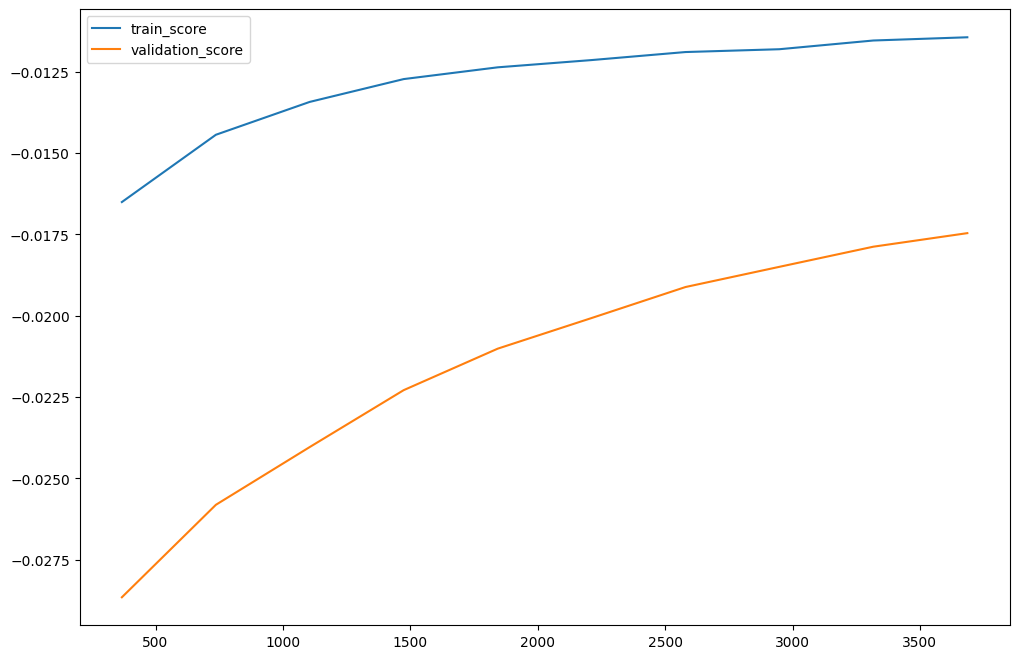

In [47]:
evaluation(model)

# Explaining Model 

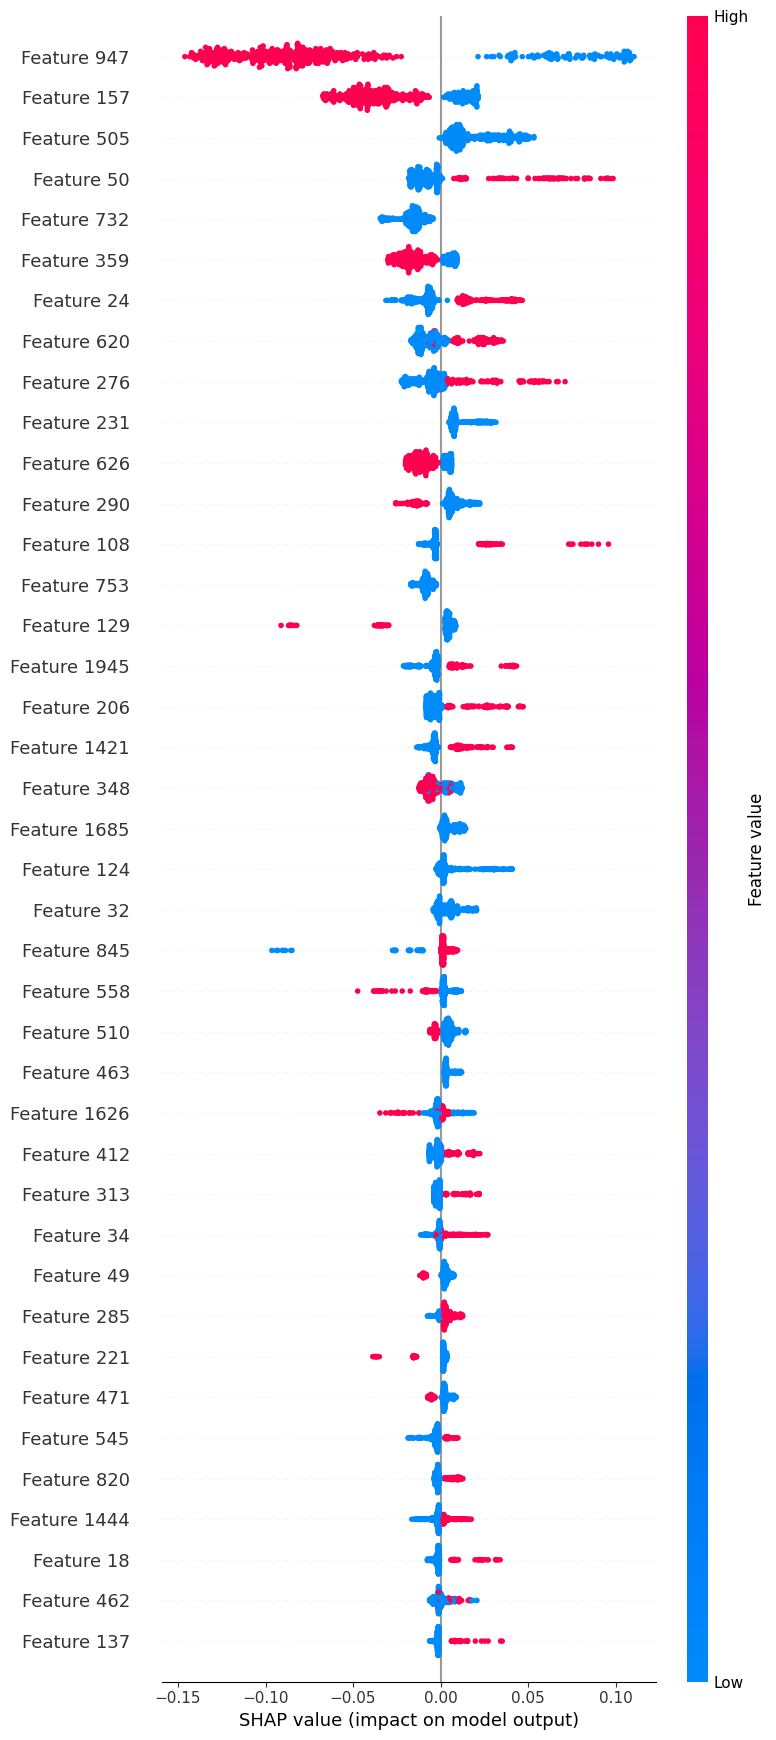

In [48]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:500])
shap.summary_plot(shap_values,X[:500] , max_display=40)

Feature 947 and 157, their absence have a positive effect on the model output.

In [49]:
sub = list(mapping.get(947))[0].replace("c", "C")
print(sub)
x = Chem.MolFromSmiles(sub)

[CH2]([CH3])[CH3]


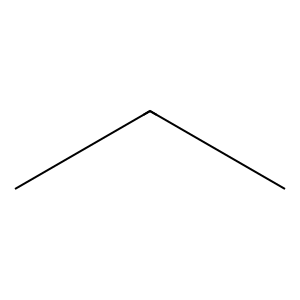

In [50]:
Draw.MolToImage(x)

[CH]1[CH][C]([NH])[CH][CH][C]1[Cl]


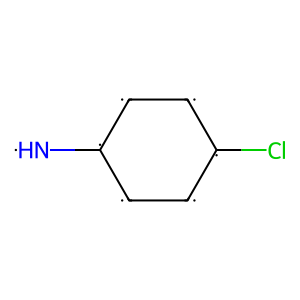

In [51]:
sub = list(mapping.get(157))[0].replace("c", "C").replace("n", "N")
print(sub)
Chem.MolFromSmiles(sub)

The presence of feature 50 seems to have a positive influence on the model output

[C]1([P]([CH]([CH3])[CH3])[CH]([CH3])[CH3])[CH][CH][CH][CH][C]1-[C]([CH2])[CH2]


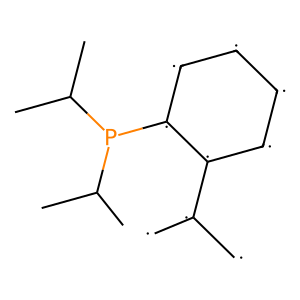

In [53]:
sub = list(mapping.get(50))[0].replace("c", "C")
print(sub)
Chem.MolFromSmiles(sub)

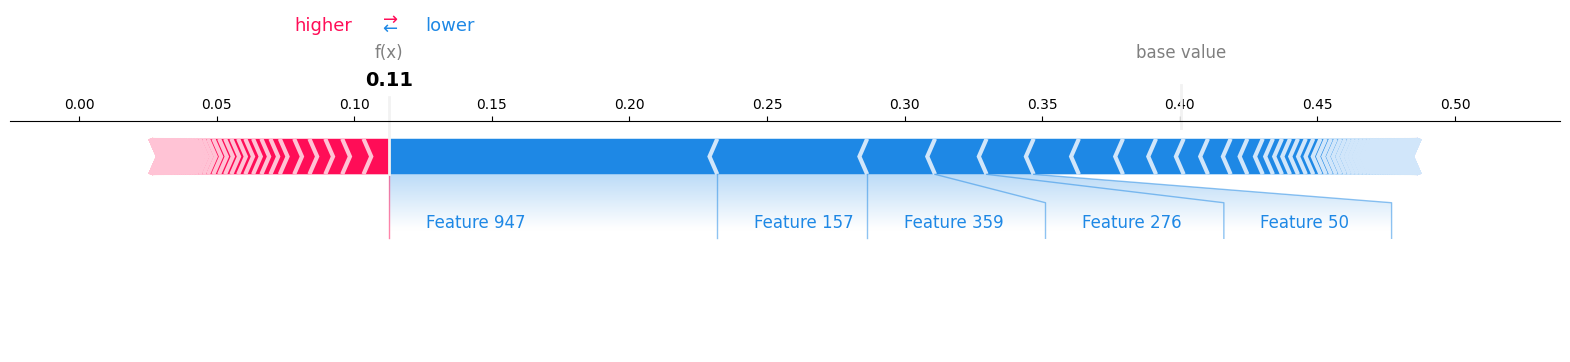

In [54]:
shap.force_plot(explainer.expected_value, shap_values[0,:], matplotlib=True)

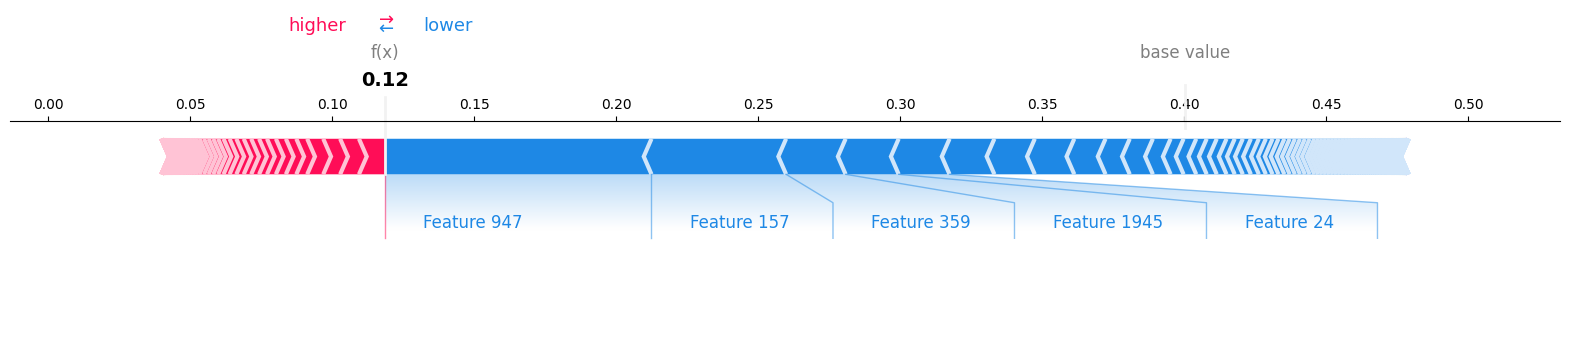

In [55]:
shap.force_plot(explainer.expected_value, shap_values[100,:], matplotlib=True)

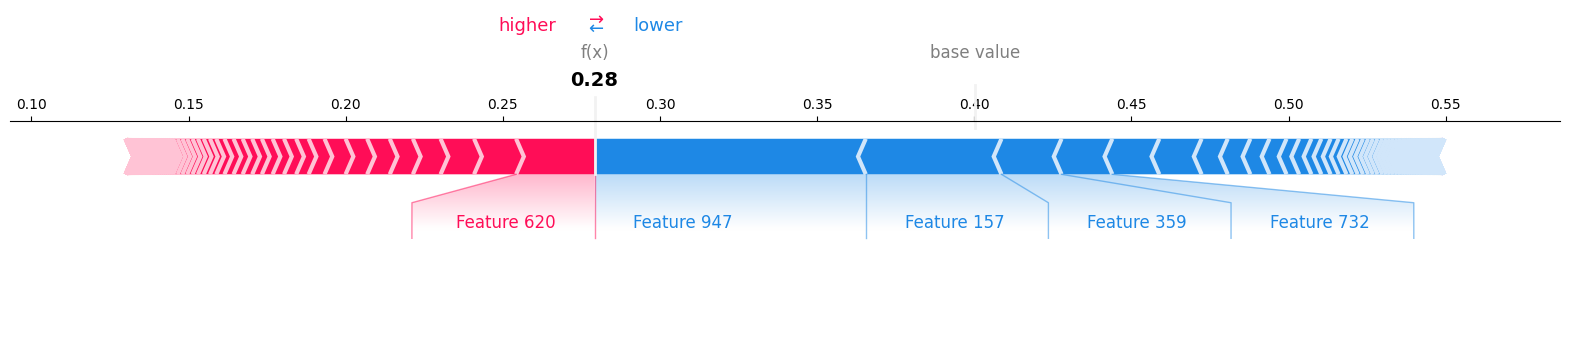

In [56]:
shap.force_plot(explainer.expected_value, shap_values[300,:], matplotlib=True)